<a href="https://colab.research.google.com/github/andreagurioli1995/CLIPasFewShotClassifier/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CLIP zero shot and few shot classifier testing


## Import dependencies


In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ca7j366j
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ca7j366j


In [2]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import skimage

import clip #importing clip model

print("Torch version:", torch.__version__)


Torch version: 1.11.0+cu113


##Setting runtime enviroment
Setup your runtime to GPU if available



In [3]:
device = "cpu"
if torch.cuda.is_available:
  print('Gpu available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

!nvidia-smi

Gpu available
Tue Jun 21 14:40:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

## Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f5e1773e560>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.
As we can see, the 49406 token is the Start of sentence token and the 49407 is the EOS token

In [7]:
clip.tokenize("my text is going to be tokenized!")

tensor([[49406,   607,  4160,   533,  1245,   531,   655, 32634,  7690,   256,
         49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

##Testing CLIP features

In [8]:


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

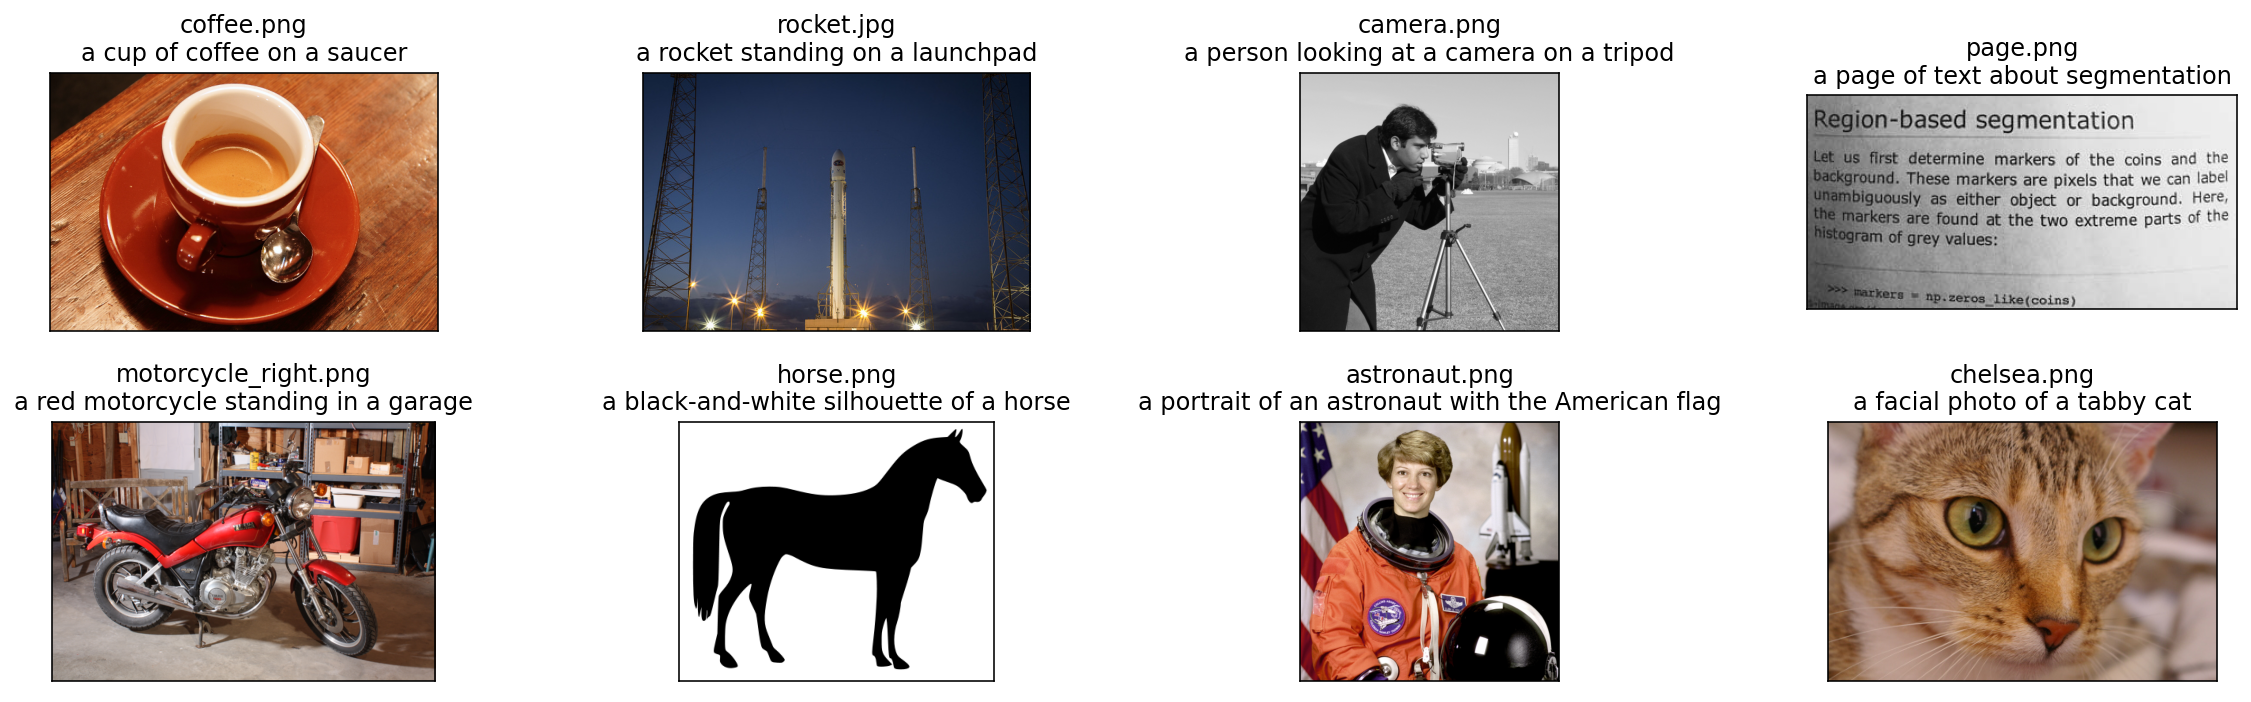

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


### Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [10]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [11]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

### Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [12]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

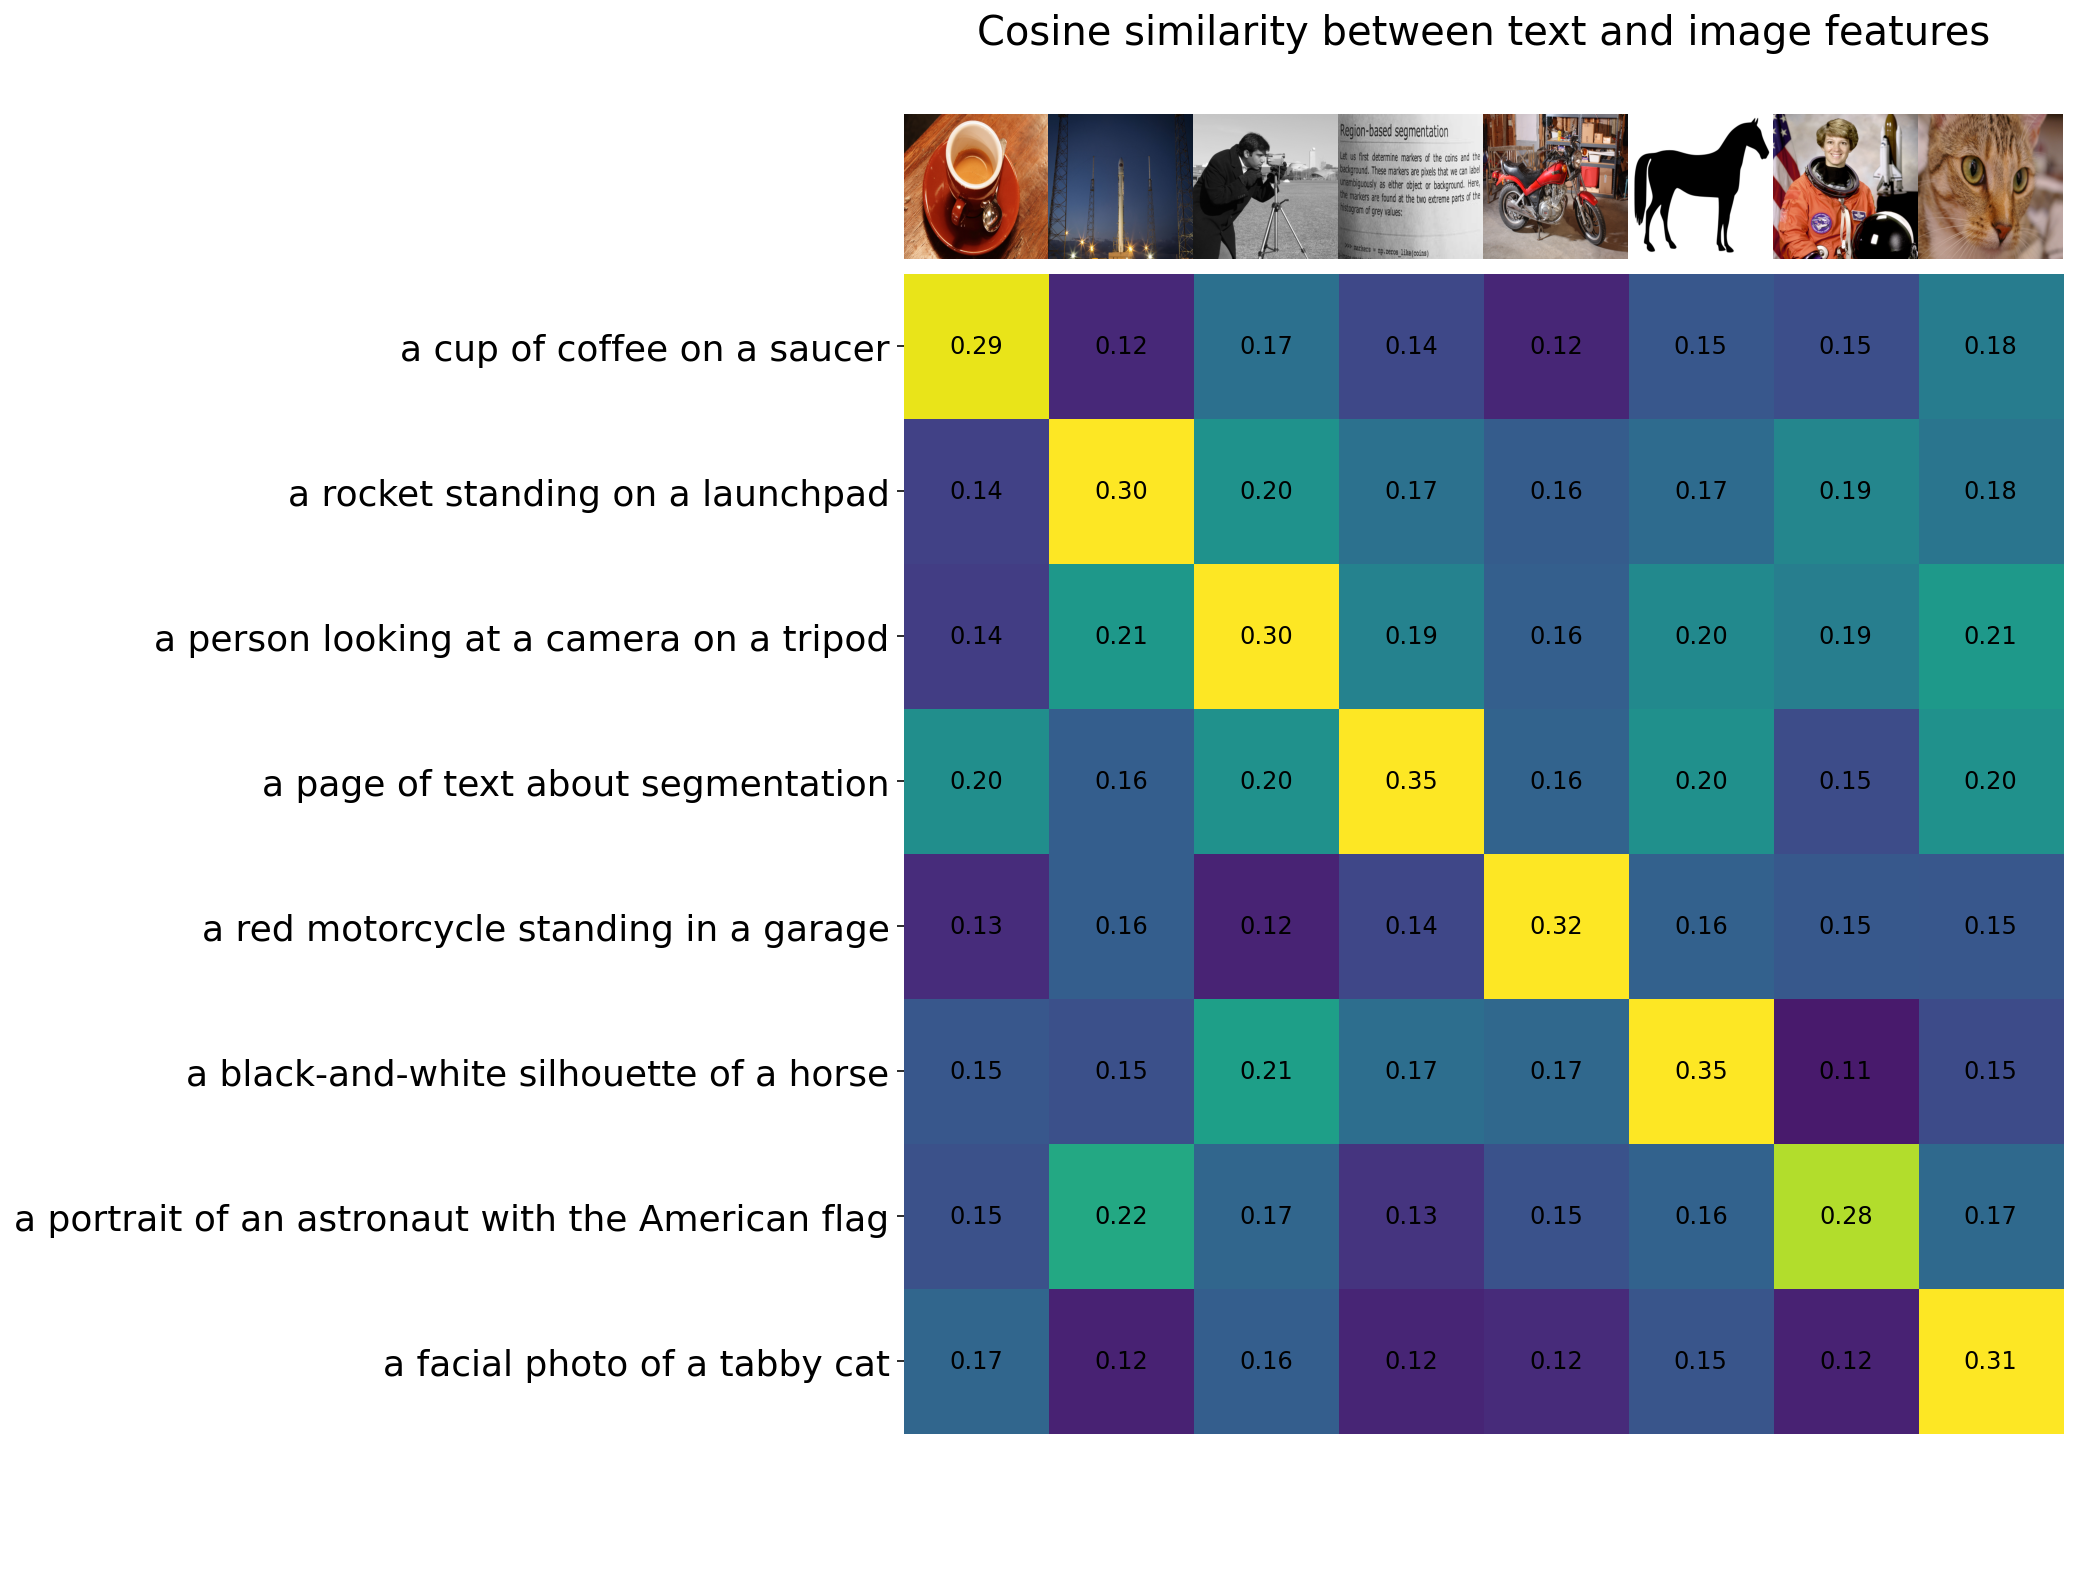

In [13]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [14]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


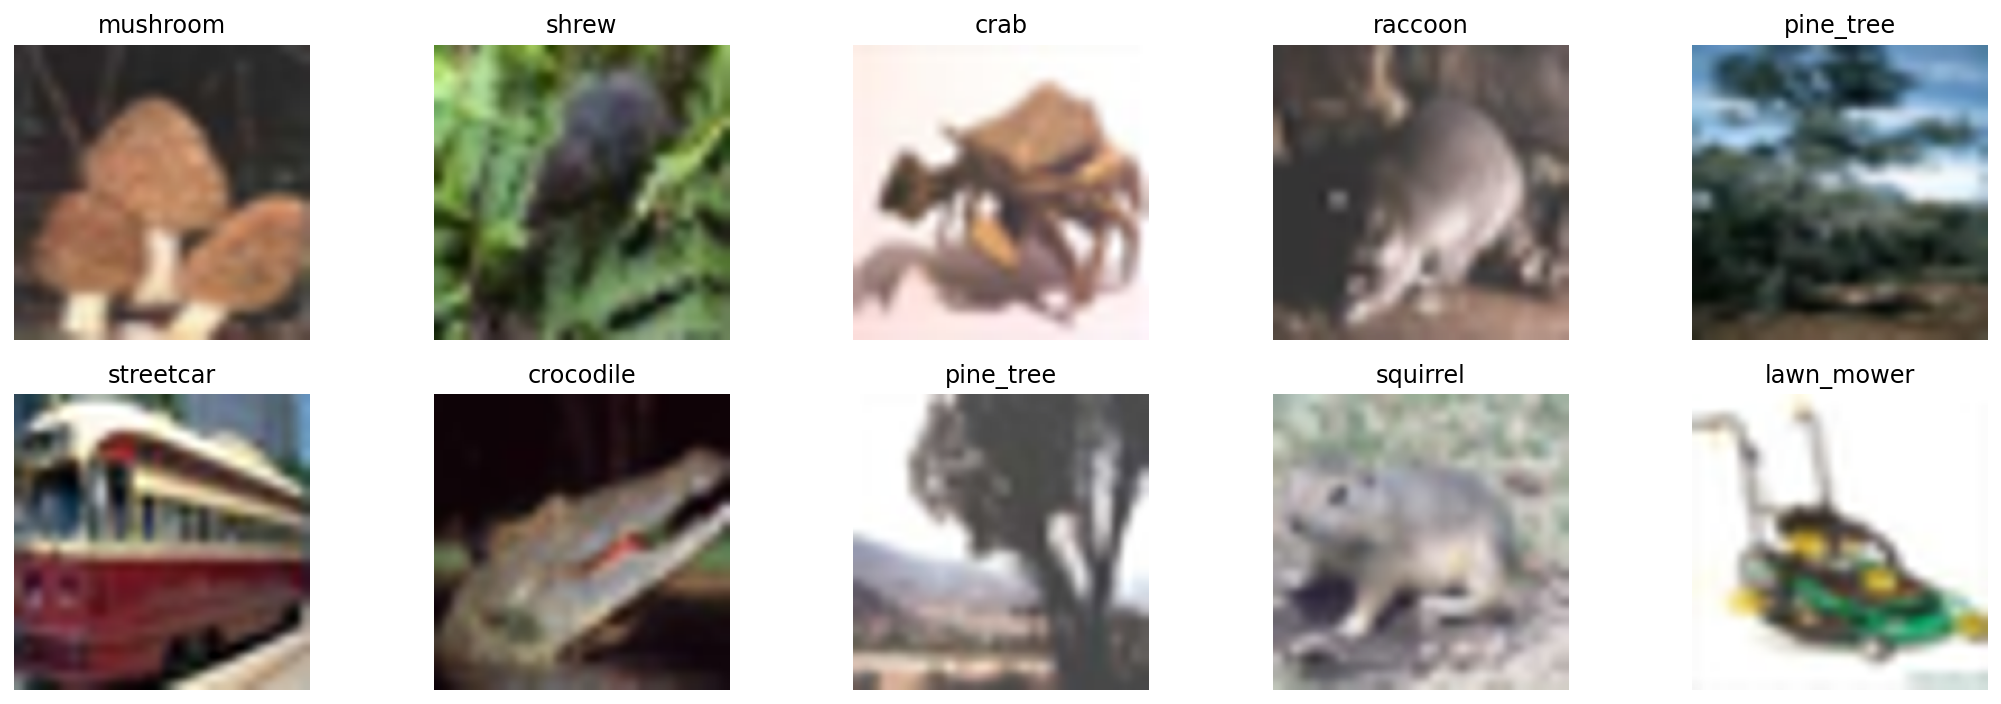

In [15]:
mean_CIFAR100 = [0.48145466, 0.4578275, 0.40821073]
std_CIFAR100 = [0.26862954, 0.26130258, 0.27577711]
class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean_CIFAR100, std_CIFAR100)
show_grid(cifar100, process=denormalize)

## Image encoding

In [16]:
train_set, val_set, test_set = torch.utils.data.random_split(cifar100, [40000, 8000,2000])
print(cifar100)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /root/.cache
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7f5e1773e560>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )


In [17]:
image_input = torch.tensor(np.stack([test_set[x][0] for x in range(len(test_set))])).cuda()
labels = torch.tensor(np.stack([test_set[x][1] for x in range(len(test_set))]))
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

## Data ensembling and text encoding
As mentioned in the paper, CLIP works as a natual language supervised algorithm, given that, manipulating labels can give better results.
We are going to compare the results with and without **ensembling**

In [18]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]

text_tokens_ensembled = clip.tokenize(text_descriptions).cuda()
text_tokens = clip.tokenize(cifar100.classes).cuda()

In [19]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features_ensembled = model.encode_text(text_tokens_ensembled).float()
    text_features_ensembled /= text_features_ensembled.norm(dim=-1, keepdim=True)

#text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
text_probs = (100.0 * image_features @ text_features_ensembled.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Overall zero shot accuracy computation

In [20]:
correct_labels = 0
for index, prediction in enumerate(top_labels):
  if prediction[0]==labels[index]:
    correct_labels=correct_labels+1
print("The overall accuracy for the CLIP Zero shot model is: {}".format((correct_labels/len(top_labels))))

The overall accuracy for the CLIP Zero shot model is: 0.5875


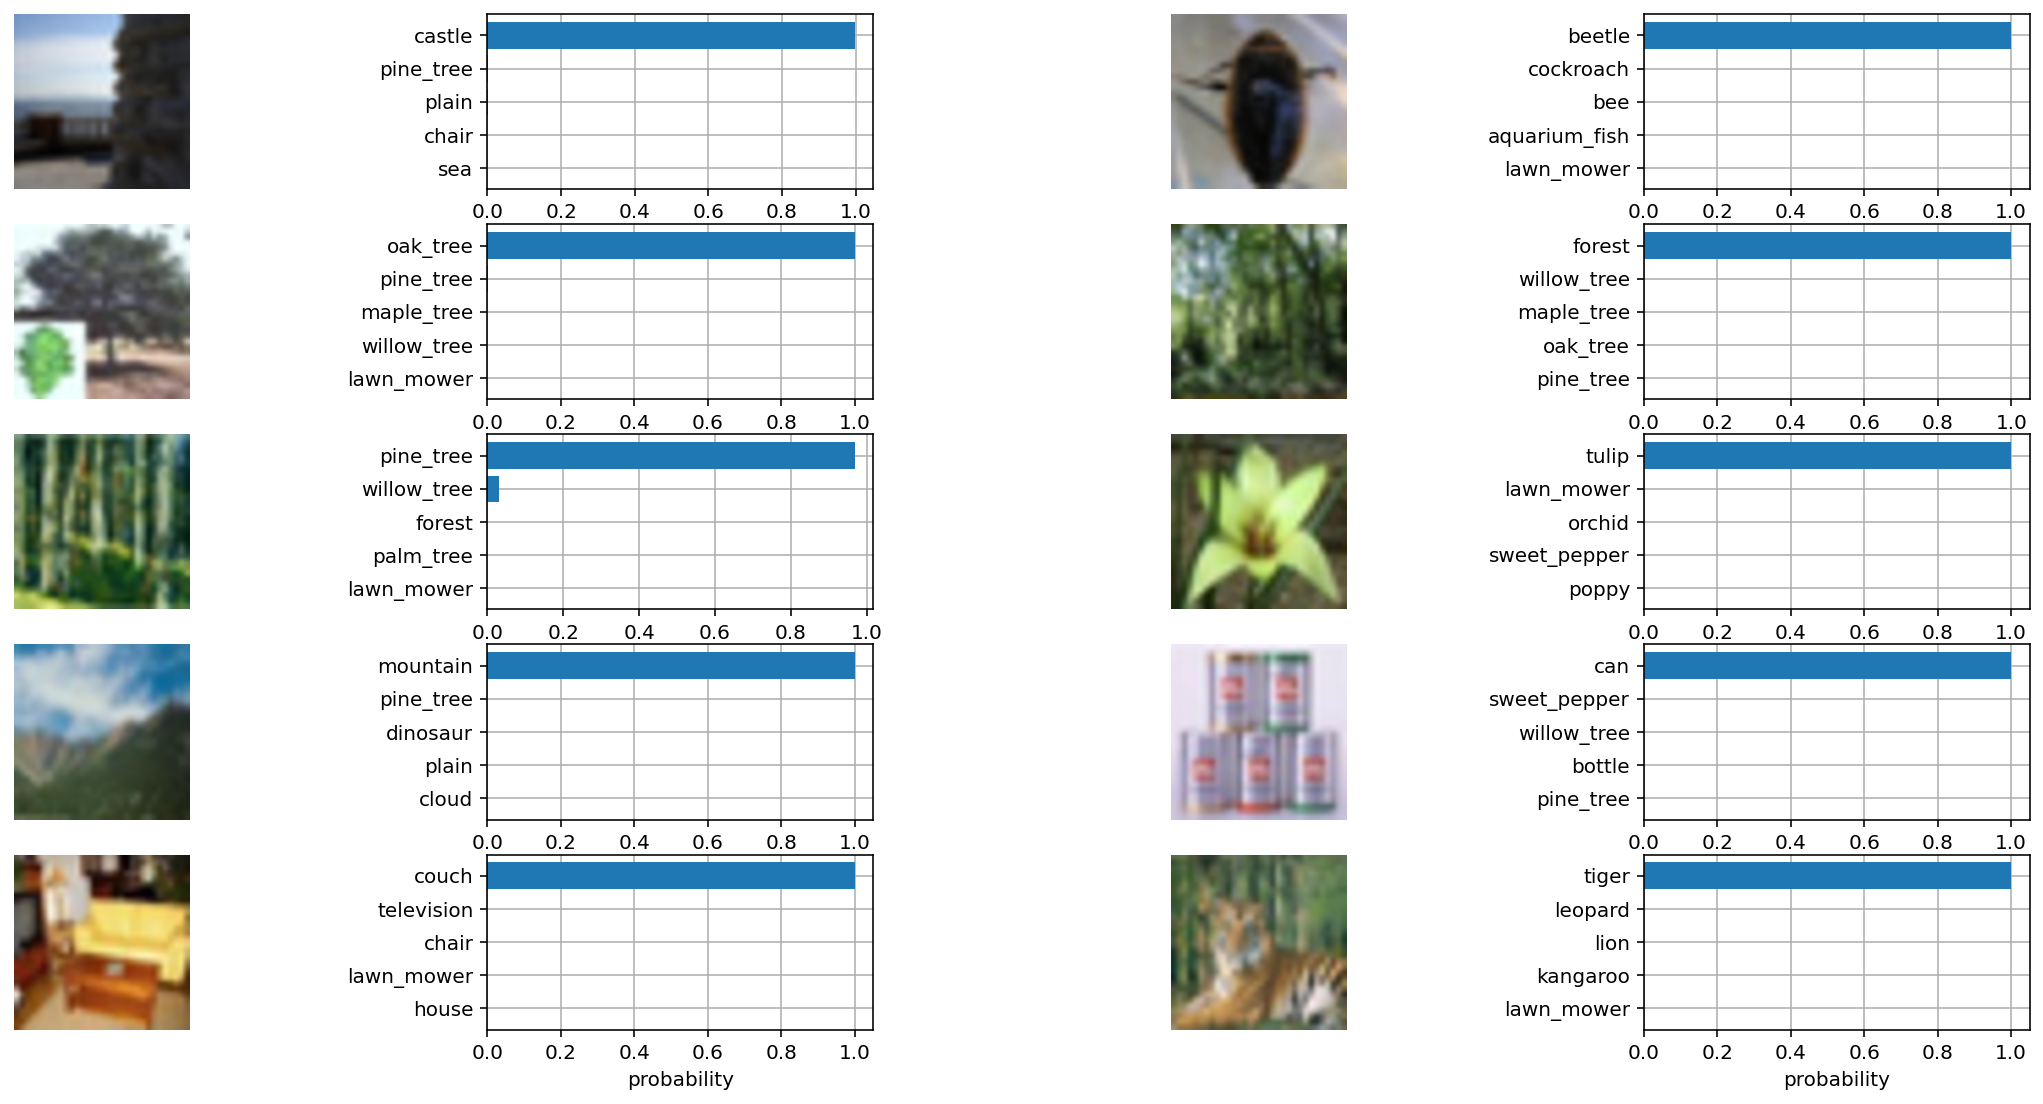

In [21]:
plt.figure(figsize=(19, 19))
#taking random index for random sampling
random_index = np.random.randint(10, size=10, high=len(image_input))
image_input_sample = [(image_input[x],x) for x in random_index] 
for i, image in enumerate(image_input_sample):
    plt.subplot(len(image_input_sample), 4, 2 * i + 1)
    #denormalizing the image and transforming to PIL image
    image_processed = denormalize(image[0].cpu())
    plt.imshow(transforms.ToPILImage()(image_processed))

    plt.axis("off")

    plt.subplot(len(image_input_sample), 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[image[1]])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[image[1]].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

##Few shot experiment
In this part of the notebook, we are going to use the vision encoder as a feature extractor for a logistic regression in order to replicate the few-shot experiment 

In [22]:
NUM_CLASSES = len(cifar100.classes)
print(NUM_CLASSES)


linear_probe_model = nn.Sequential(
    model.visual,
    #nn.Identity(),
    nn.Linear(512, NUM_CLASSES, dtype=torch.float16)
)
linear_probe_model.eval()
linear_probe_model.to(device)

100


Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

Setting up the datased for few shot classification

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


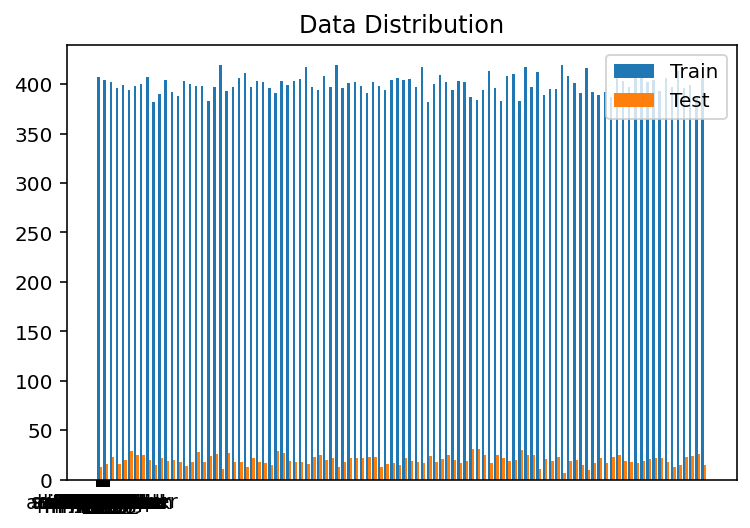

In [23]:
def plot_histograms(dataset_train: torchvision.datasets.ImageFolder,
                    dataset_test: torchvision.datasets.ImageFolder,
                    overall_set: torchvision.datasets.ImageFolder,
                    title: str,
                    classes_as_ticks: bool = True) -> None:
    """Plot histograms with train and test or validation data distributions.

    Args:
        dataset_train: the train dataset.
        dataset_test: the test or validation dataset.
        title: the title of the plot.
        classes_as_ticks: if true the name of the classes are show in the x axis.
    """
    classes = len(overall_set.classes)
    bins = np.linspace(0, classes, classes + 1, dtype=int)
    plt.title(title)
    plt.hist([[dataset_train[x][1] for x in range(len(dataset_train))], [dataset_test[x][1] for x in range(len(dataset_test))]], bins=bins, 
             label=['Train', 'Test'])
    
    plt.legend(loc='upper right')
    
    if classes_as_ticks:
        x_ticks_names = overall_set.classes +  overall_set.classes
        step = 1 / len(x_ticks_names)    
        x_ticks_pos = [(x * step) for x in np.arange(2 * len(x_ticks_names))][1::2]    
        
        plt.xticks(x_ticks_pos, x_ticks_names)
    plt.show()

plot_histograms(train_set, test_set,cifar100, "Data Distribution")

In [24]:
check_len = [0 for x in range(100)]
few_shot_train = []
for x in train_set:
  if check_len[x[1]]<12:
    check_len[x[1]] = check_len[x[1]]+1
    few_shot_train.append(x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


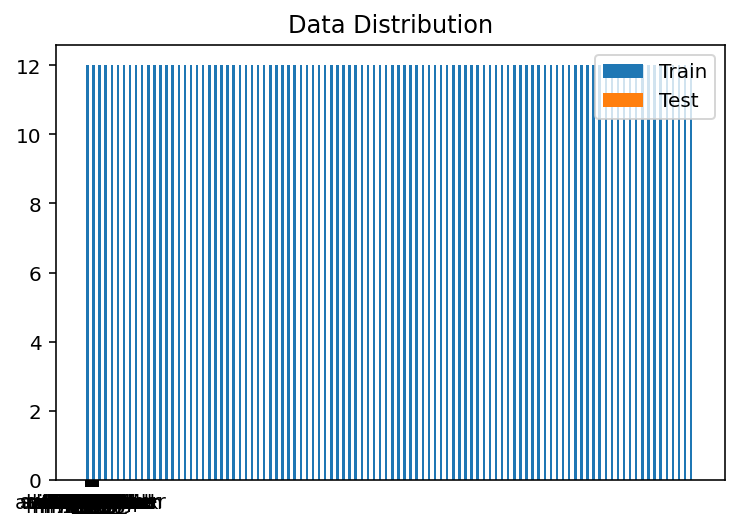

In [25]:
plot_histograms(few_shot_train,[],cifar100, "Data Distribution")

### Feature extraction for few shot classifier

In [26]:
# Accuracy
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Gets the number of correctly classified examples.

    Args:
        scores: the scores predicted with the network.
        labels: the class labels.

    Returns: 
        the number of correct samples.
    """
    classes_predicted = torch.argmax(scores, 1)
    return (classes_predicted == labels).sum().item()

# Train one epoch
def train(writer: utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
        the accuracy on the training data.
    """    
    correct = 0
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)

        loss = criterion(scores, labels)
        loss_train += loss.item() * len(images)
        samples_train += len(images)        

        loss.backward()
        optimizer.step()
        correct += get_correct_samples(scores, labels)

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches) 
                writer.add_scalar('Metrics/Loss_Train_IT', running_loss, global_step)
                # Visualize images on tensorboard
                indices_random = torch.randperm(images.size(0))[:4]                
                writer.add_images('Samples/Train', denormalize(images[indices_random]), global_step)
                
    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

# Validate one epoch
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data.
        the accuracy on the validation data.
    """
    correct = 0
    samples_val = 0
    loss_val = 0.
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            scores = model(images)

            loss = criterion(scores, labels)
            loss_val += loss.item() * len(images)
            samples_val += len(images)
            correct += get_correct_samples(scores, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

In [27]:
def training_loop(writer: utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.
            the values for the validation accuracy for each epoch.
            the time of execution in seconds for the entire loop.
    """
    criterion = nn.CrossEntropyLoss()    
    loop_start = timer()

    losses_values = []
    train_acc_values = []
    val_acc_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train, accuracy_train = train(writer, model, loader_train, device, 
                                           optimizer, criterion, log_interval, 
                                           epoch)
        loss_val, accuracy_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values.append(loss_train)
        train_acc_values.append(accuracy_train)
        val_acc_values.append(accuracy_val)
        
        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Plot to tensorboard        
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalars('Metrics/Losses', {"Train": loss_train, "Val": loss_val}, epoch)
        writer.add_scalars('Metrics/Accuracy', {"Train": accuracy_train, "Val": accuracy_val}, epoch)
        writer.flush()
        
        # Increases the internal counter
        if lr_scheduler:            
            lr_scheduler.step()            
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'loss_values': losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

In [28]:
dtype = torch.HalfTensor
NfSt = []
Nts=[]
for tensor in few_shot_train:
  NfSt=[*NfSt,*[(tensor[0].type(dtype),tensor[1])]]
for tensor in test_set:
  Nts=[*Nts,*[(tensor[0].type(dtype),tensor[1])]]


In [29]:
num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(NfSt, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(Nts, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
def execute(name_train: str, network: nn.Module, starting_lr: float, 
            num_epochs: int, 
            data_loader_train: torch.utils.data.DataLoader,
            data_loader_val: torch.utils.data.DataLoader) -> None:
    """Executes the training loop.

    Args:
        name_train: the name for the log subfolder.
        network: the network to train.
        starting_lr: the staring learning rate.
        num_epochs: the number of epochs.
        data_loader_train: the data loader with training data.
        data_loader_val: the data loader with validation data.
    """
    # Visualization 
    log_interval = 20
    log_dir = os.path.join("logs", name_train)
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir)
    
    # Optimization
    optimizer = optim.SGD(network.parameters(), lr=starting_lr, momentum=0.9, 
                          weight_decay=0.0001)

    # Learning Rate schedule: decays the learning rate by a factor of `gamma` 
    # every `step_size` epochs
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    scheduler = None

    statistics = training_loop(writer, num_epochs, optimizer, scheduler, 
                               log_interval, network, data_loader_train, 
                               data_loader_val)
    writer.close()

    best_epoch = np.argmax(statistics['val_acc_values']) + 1
    best_accuracy = statistics['val_acc_values'][best_epoch - 1]

    print(f'Best val accuracy: {best_accuracy:.2f} epoch: {best_epoch}.')

In [43]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
%tensorboard --logdir="logs"

Reusing TensorBoard on port 6006 (pid 843), started 2:17:12 ago. (Use '!kill 843' to kill it.)

<IPython.core.display.Javascript object>

In [33]:
def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.
        
        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [34]:
#freezing parameters for feature extraction
set_requires_grad_for_layer(linear_probe_model[0], False)
set_requires_grad_for_layer(linear_probe_model[1], True)

In [52]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1  Lr: 0.00100000  Loss: Train = [2.1161] - Val = [2.5485]  Accuracy: Train = [83.08%] - Val = [59.55%]  Time one epoch (s): 6.2601 
Epoch: 2  Lr: 0.00100000  Loss: Train = [2.1146] - Val = [2.5468]  Accuracy: Train = [83.17%] - Val = [59.35%]  Time one epoch (s): 6.2809 
Epoch: 3  Lr: 0.00100000  Loss: Train = [2.1124] - Val = [2.5448]  Accuracy: Train = [83.08%] - Val = [59.40%]  Time one epoch (s): 6.2908 
Epoch: 4  Lr: 0.00100000  Loss: Train = [2.1100] - Val = [2.5424]  Accuracy: Train = [83.08%] - Val = [59.85%]  Time one epoch (s): 6.2658 
Epoch: 5  Lr: 0.00100000  Loss: Train = [2.1072] - Val = [2.5408]  Accuracy: Train = [83.17%] - Val = [59.70%]  Time one epoch (s): 6.2357 
Epoch: 6  Lr: 0.00100000  Loss: Train = [2.1050] - Val = [2.5391]  Accuracy: Train = [83.25%] - Val = [60.20%]  Time one epoch (s): 6.2320 
Epoch: 7  Lr: 0.00100000  Loss: Train = [2.1021] - Val = [2.5378]  Accuracy: Train = [83.17%] - Val = [59.75%]  Time one epoch (s): 6.3658 
Epoch: 8  Lr: 0.0010